In [1]:
#! pip install pandas
#! pip install matplotlib

#interactive plots
#%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json

If you want to use and support this project, you should contact me (info@zrod.io)

Note: the API is currently open. I'm going to restrict this in the future, so any changes will likely break.

In [3]:
url = "https://api.zrod.io/design"

__Demo design__. Most of the parameters should be self explanatory. This data structure will also likely change, so just be aware this will eventually break things.

In [4]:
demo = {
    "id":9999,
    "WellName":"TestWellName",
    "SPM":6.3,
    "Fo":3000,
    "SG":1,
    "fillage":0.75,
    "Taper":[
        {"L":3000,"D":1.0,"W":2.904,"Emod":30.5e6,"Rho":490},
        {"L":3000,"D":0.875,"W":2.224,"Emod":30.5e6,"Rho":490},
        {"L":3000,"D":0.75,"W":1.63,"Emod":30.5e6,"Rho":490}
    ],
    "Dup":0.5,
    "Ddn":0.2,
    "PU":{
        "Rotate":1,
        "A":129,
        "P":132,
        "C":111.07205,
        "I":111,
        "K":175.55,
        "R":42,
        "Torque":320,
        "Structure":298,
        "MaxStroke":100,
        "Type":"C",
        "Double":False,
        "CBE":15418,
        "B":550
    },
    "tmpTS": 10, #TODO: change to tubing kt or tubing specs
    "dyno": [[0.00,4660],[0.20,4814],[0.69,5012],[1.69,5100],[2.68,5738],[4.17,6331],[5.85,7079],[7.74,7870],[8.83,8200],[10.91,8815],[13.29,8266],[15.87,7694],[18.65,7035],[21.72,6331],[24.70,5584],[27.77,5408],[30.75,5650],[34.02,5936],[37.10,6353],[40.07,6771],[42.95,7123],[46.03,6815],[48.90,6551],[51.88,6243],[54.75,5826],[57.43,5210],[59.81,5144],[62.29,5276],[64.67,5408],[66.86,5518],[68.84,6111],[70.72,6529],[72.71,6507],[74.39,6397],[76.08,6199],[77.47,5979],[78.96,5408],[80.15,5364],[81.44,5452],[82.33,5584],[83.32,5716],[84.02,6155],[84.81,6419],[85.31,6353],[85.60,6199],[86.00,6111],[86.00,5826],[86.00,5298],[86.00,5100],[85.70,5012],[85.31,5012],[84.51,4792],[83.82,4660],[82.63,3869],[81.54,3298],[80.15,2792],[78.56,2418],[76.87,1979],[75.09,2110],[72.91,2550],[70.72,2902],[68.44,3056],[65.96,3341],[63.48,3473],[60.81,3188],[58.13,2990],[55.35,2770],[52.57,2638],[49.70,2440],[46.62,2572],[43.64,2704],[40.67,2770],[37.79,2990],[34.92,3056],[31.84,3122],[29.06,3078],[26.19,3056],[23.41,3034],[20.73,3078],[18.15,3122],[15.47,3210],[13.09,3385],[10.91,3539],[8.93,3649],[7.04,3803],[5.36,3957],[3.87,4001],[2.68,4001],[1.49,4111],[0.79,4133]]
}

Future API versions will require credential and a unique key.

In [5]:
headers = {
    "Content-type": "application/json",
    "Accept": "application/json",
    "x-api-key": "De9psKiZs88x44oVc8SFraX5cBebrCmh3DsBGcJR"
}

A bunch of data is returned by the API. This just plots the predicted surface and pump cards.

In [6]:
def PlotResults(respx, title):
    df = pd.DataFrame(data=respx.json()["Pmp"], columns=["PmpPos", "PmpLoad"])

    SfcPos, SfcLoad = tuple(zip(*respx.json()["Sfc"]))
    df.insert(2, "SfcLoad", SfcLoad, True)
    df.insert(2, "SfcPos", SfcPos, True)

    ax = plt.gca()
    
    df.plot(kind="scatter", x="SfcPos", y="SfcLoad", ax=ax, s=1, color="red")
    df.plot(kind="scatter", x="PmpPos", y="PmpLoad", ax=ax, s=1, color="green")
    
    plt.title(title)
    plt.xlabel('Position')
    plt.ylabel('Load')

    plt.show()

    return(df)
#end PlotResults()

Given a parameter (see the demo dict above), run the design for each value from **start** to **stop** by each **step** value. Because this modifies the __param__, you should pass in a copy of the data dict.

In [7]:
def DoLoop(data, param, start, stop, step):
    #np.arrange has some issues with floating point steps and last value
    numpoints = int((stop-start) / step) + 1
    print("numpoints", numpoints)
    
    for i in np.linspace(start, stop, num=numpoints, endpoint=True, retstep=False):
        data[param] = float(np.around(i, 2))
        print(f'Processing - {param}: {data[param]}...')
        resp = requests.post(url, data=json.dumps(data), headers=headers)
        j = resp.json()
        print(f'Results >>> PPRL: {j["PPRL"]}, MPRL: {j["MPRL"]}:')
        df = PlotResults(resp, f'{param}: {data[param]}')
        print("----------------------------------------------")
    #end for
    print("Done processing", param, "values.")
#end DoLoop()

***

Take a peek at the data returned by the API. It's a lot, so switch this to a code block to see it (the drop-down in the toolbar that says "Raw NBConvert"). Again, the output data structure is likely to change, so be prepared for breaking changes. Make sure you double check (and triple check) all the results.

***

Here's where the fun stuff starts. Run a bunch of designs for a range of param values. Uncomment ***%matplotlib notebook*** above to use the same plot. Otherwise, it'll just plot a bunch of static images (which are easier to see, but maybe not as amusing)

numpoints 16
Processing - fillage: 0.25...
Results >>> PPRL: 24707, MPRL: 15287:


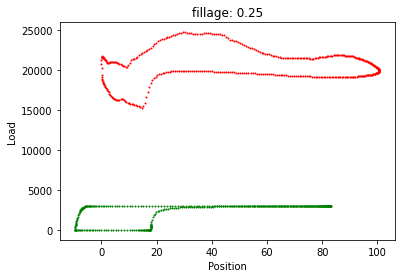

----------------------------------------------
Processing - fillage: 0.3...
Results >>> PPRL: 24680, MPRL: 15039:


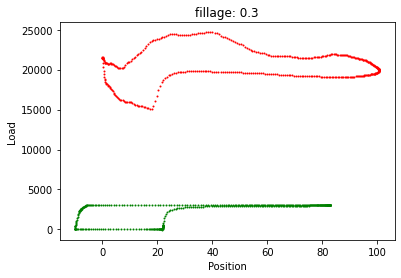

----------------------------------------------
Processing - fillage: 0.35...
Results >>> PPRL: 24508, MPRL: 14803:


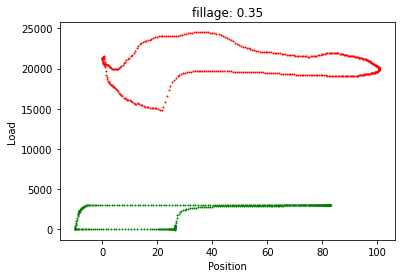

----------------------------------------------
Processing - fillage: 0.4...
Results >>> PPRL: 24386, MPRL: 14599:


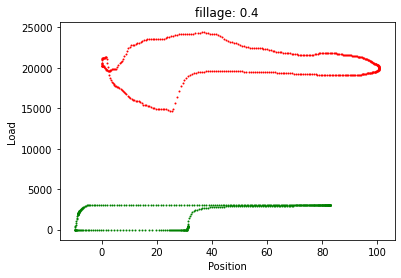

----------------------------------------------
Processing - fillage: 0.45...
Results >>> PPRL: 24214, MPRL: 14422:


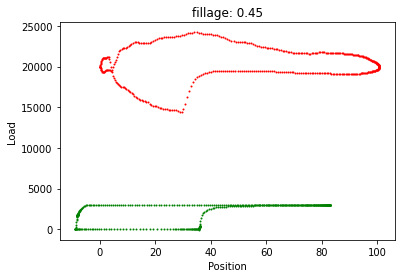

----------------------------------------------
Processing - fillage: 0.5...
Results >>> PPRL: 24220, MPRL: 14279:


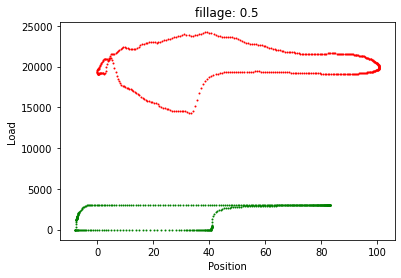

----------------------------------------------
Processing - fillage: 0.55...
Results >>> PPRL: 24412, MPRL: 14262:


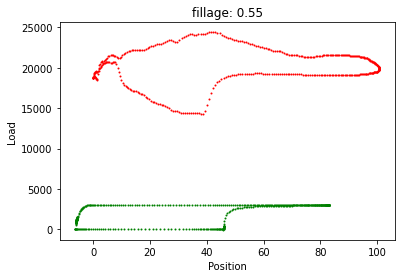

----------------------------------------------
Processing - fillage: 0.6...
Results >>> PPRL: 24573, MPRL: 14324:


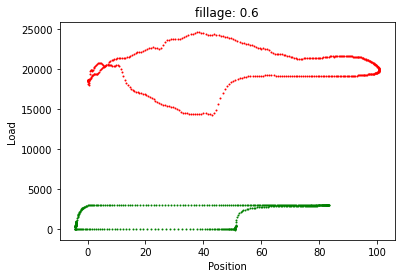

----------------------------------------------
Processing - fillage: 0.65...
Results >>> PPRL: 24282, MPRL: 14388:


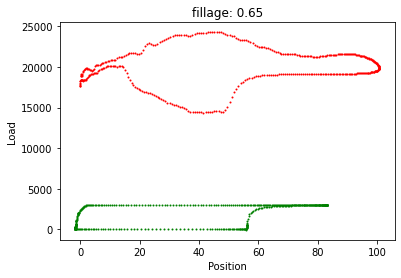

----------------------------------------------
Processing - fillage: 0.7...
Results >>> PPRL: 24383, MPRL: 14455:


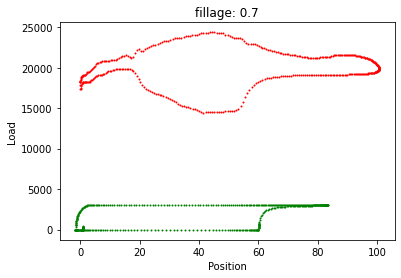

----------------------------------------------
Processing - fillage: 0.75...
Results >>> PPRL: 24411, MPRL: 14422:


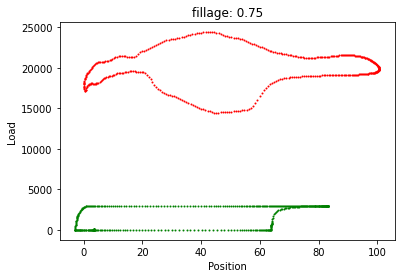

----------------------------------------------
Processing - fillage: 0.8...
Results >>> PPRL: 24397, MPRL: 14368:


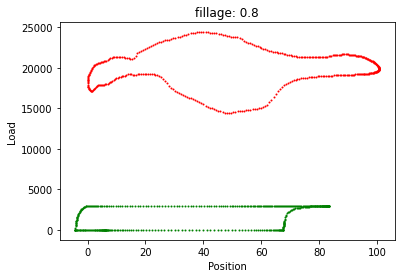

----------------------------------------------
Processing - fillage: 0.85...
Results >>> PPRL: 24411, MPRL: 14324:


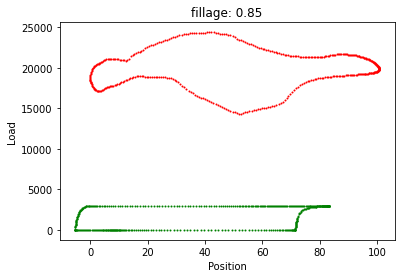

----------------------------------------------
Processing - fillage: 0.9...
Results >>> PPRL: 24520, MPRL: 14313:


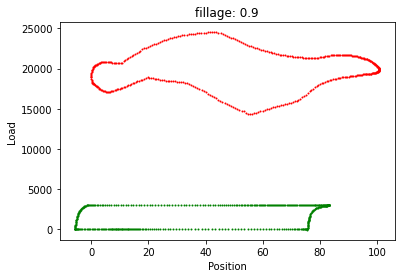

----------------------------------------------
Processing - fillage: 0.95...
Results >>> PPRL: 24460, MPRL: 14381:


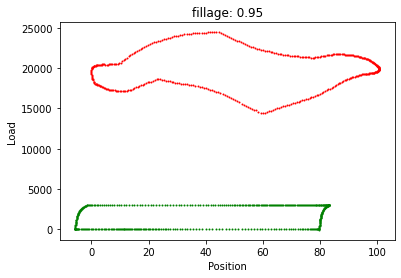

----------------------------------------------
Processing - fillage: 1.0...
Results >>> PPRL: 25083, MPRL: 14398:


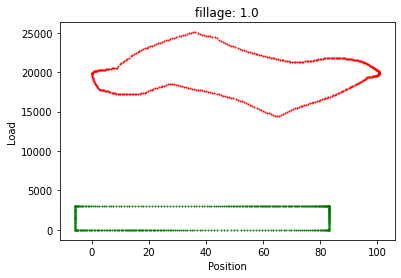

----------------------------------------------
Done processing fillage values.


In [8]:
DoLoop(demo.copy(), "fillage", 0.25, 1.0, 0.05)

***

numpoints 31
Processing - Fo: 3000.0...
Results >>> PPRL: 24411, MPRL: 14422:


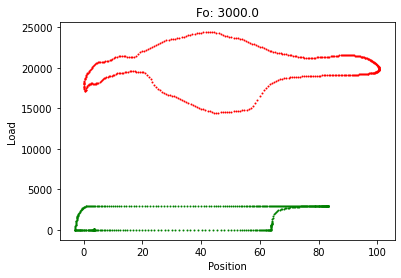

----------------------------------------------
Processing - Fo: 3100.0...
Results >>> PPRL: 24499, MPRL: 14400:


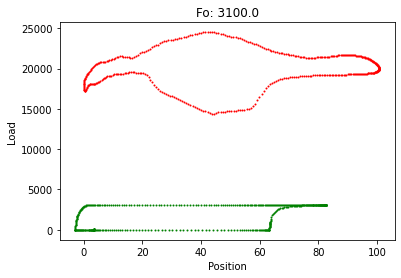

----------------------------------------------
Processing - Fo: 3200.0...
Results >>> PPRL: 24584, MPRL: 14361:


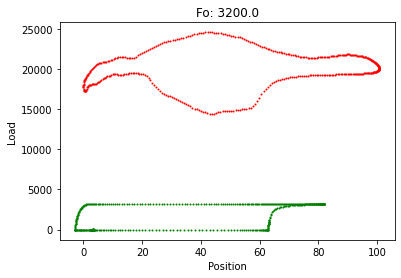

----------------------------------------------
Processing - Fo: 3300.0...
Results >>> PPRL: 24659, MPRL: 14332:


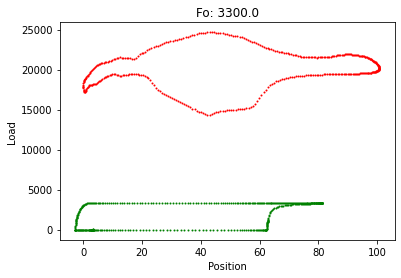

----------------------------------------------
Processing - Fo: 3400.0...
Results >>> PPRL: 24724, MPRL: 14341:


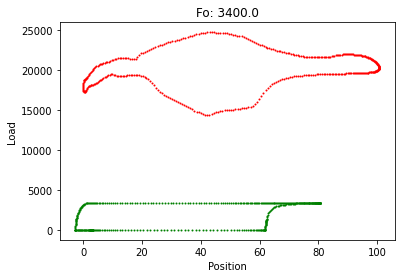

----------------------------------------------
Processing - Fo: 3500.0...
Results >>> PPRL: 24781, MPRL: 14356:


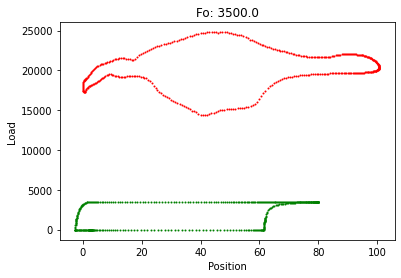

----------------------------------------------
Processing - Fo: 3600.0...
Results >>> PPRL: 24873, MPRL: 14414:


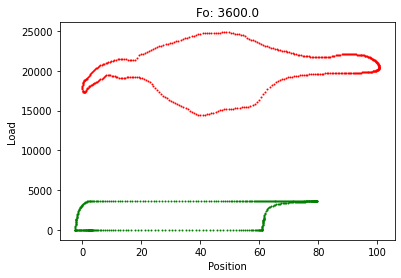

----------------------------------------------
Processing - Fo: 3700.0...
Results >>> PPRL: 24985, MPRL: 14476:


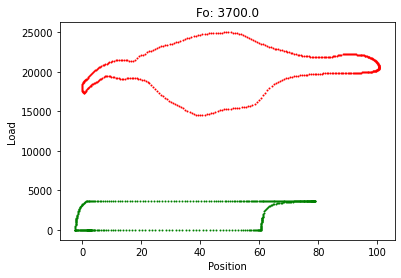

----------------------------------------------
Processing - Fo: 3800.0...
Results >>> PPRL: 25104, MPRL: 14513:


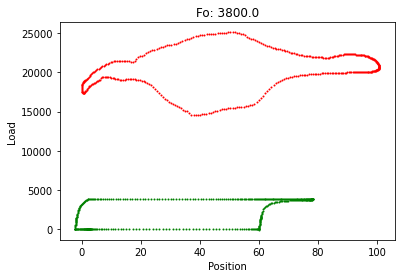

----------------------------------------------
Processing - Fo: 3900.0...
Results >>> PPRL: 25236, MPRL: 14580:


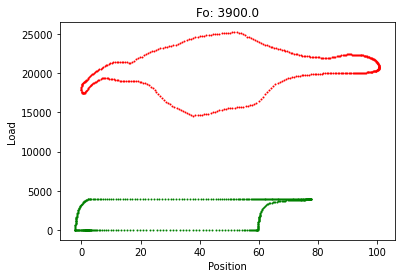

----------------------------------------------
Processing - Fo: 4000.0...
Results >>> PPRL: 25370, MPRL: 14603:


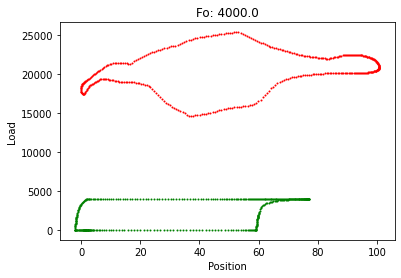

----------------------------------------------
Processing - Fo: 4100.0...
Results >>> PPRL: 25466, MPRL: 14609:


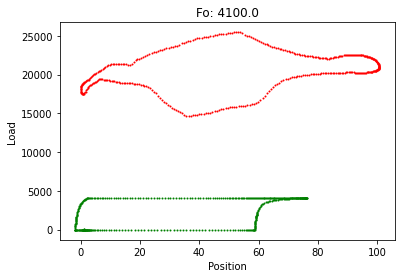

----------------------------------------------
Processing - Fo: 4200.0...
Results >>> PPRL: 25548, MPRL: 14601:


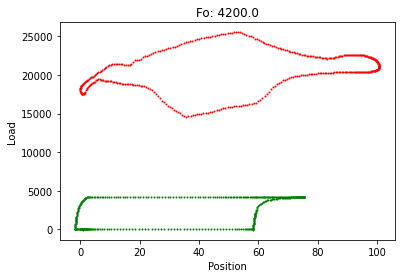

----------------------------------------------
Processing - Fo: 4300.0...
Results >>> PPRL: 25613, MPRL: 14666:


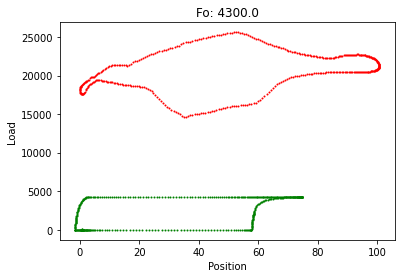

----------------------------------------------
Processing - Fo: 4400.0...
Results >>> PPRL: 25671, MPRL: 14650:


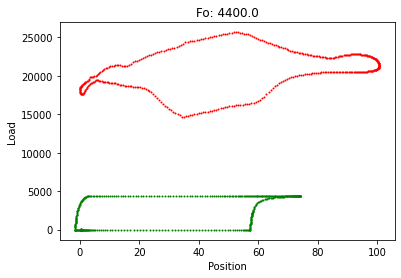

----------------------------------------------
Processing - Fo: 4500.0...
Results >>> PPRL: 25725, MPRL: 14621:


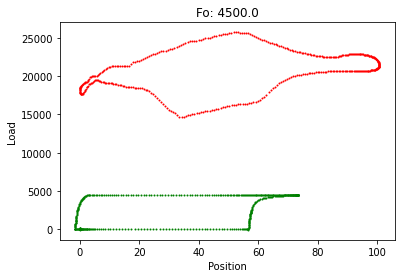

----------------------------------------------
Processing - Fo: 4600.0...
Results >>> PPRL: 25742, MPRL: 14666:


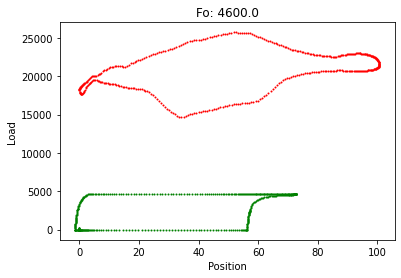

----------------------------------------------
Processing - Fo: 4700.0...
Results >>> PPRL: 25771, MPRL: 14625:


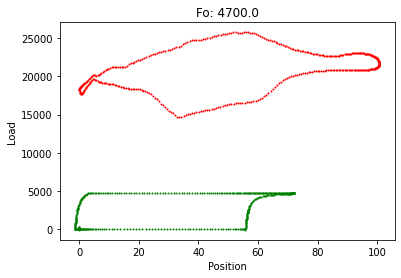

----------------------------------------------
Processing - Fo: 4800.0...
Results >>> PPRL: 25856, MPRL: 14667:


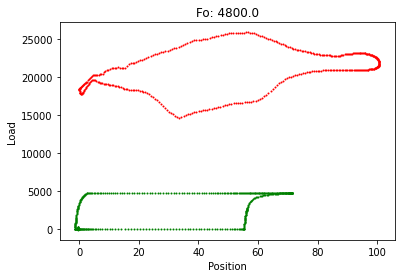

----------------------------------------------
Processing - Fo: 4900.0...
Results >>> PPRL: 25913, MPRL: 14627:


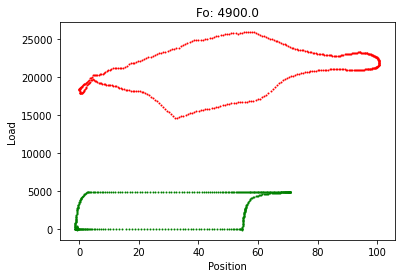

----------------------------------------------
Processing - Fo: 5000.0...
Results >>> PPRL: 26006, MPRL: 14669:


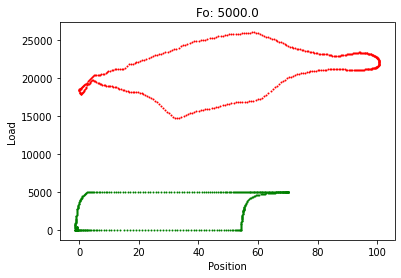

----------------------------------------------
Processing - Fo: 5100.0...
Results >>> PPRL: 26088, MPRL: 14601:


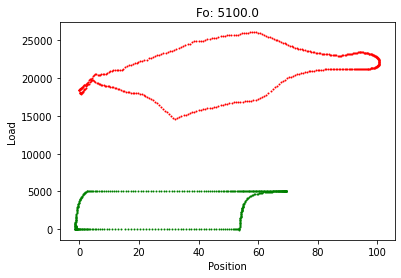

----------------------------------------------
Processing - Fo: 5200.0...
Results >>> PPRL: 26178, MPRL: 14643:


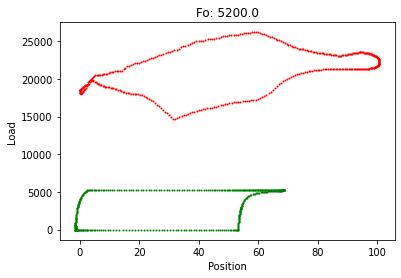

----------------------------------------------
Processing - Fo: 5300.0...
Results >>> PPRL: 26279, MPRL: 14579:


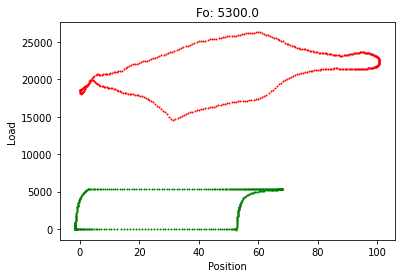

----------------------------------------------
Processing - Fo: 5400.0...
Results >>> PPRL: 26369, MPRL: 14619:


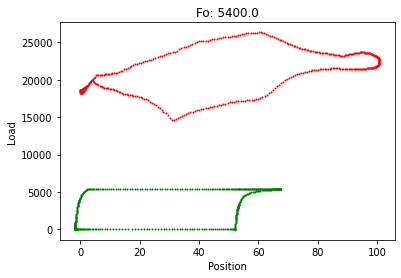

----------------------------------------------
Processing - Fo: 5500.0...
Results >>> PPRL: 26466, MPRL: 14542:


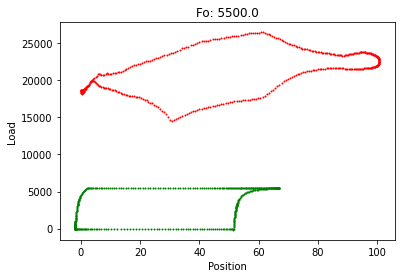

----------------------------------------------
Processing - Fo: 5600.0...
Results >>> PPRL: 26559, MPRL: 14584:


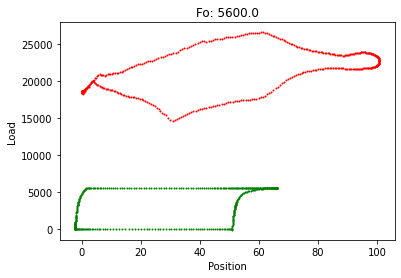

----------------------------------------------
Processing - Fo: 5700.0...
Results >>> PPRL: 26646, MPRL: 14626:


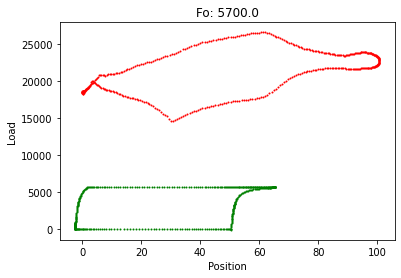

----------------------------------------------
Processing - Fo: 5800.0...
Results >>> PPRL: 26741, MPRL: 14532:


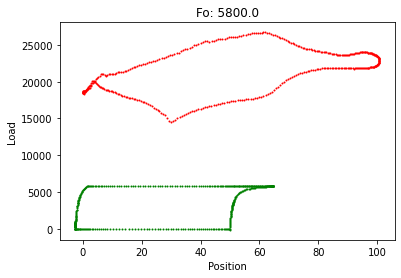

----------------------------------------------
Processing - Fo: 5900.0...
Results >>> PPRL: 26818, MPRL: 14574:


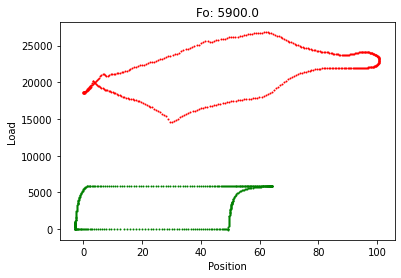

----------------------------------------------
Processing - Fo: 6000.0...
Results >>> PPRL: 26894, MPRL: 14634:


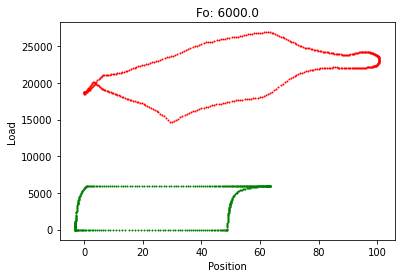

----------------------------------------------
Done processing Fo values.


In [9]:
DoLoop(demo.copy(), "Fo", 3000, 6000, 100)

***

numpoints 26
Processing - SPM: 1.0...
Results >>> PPRL: 21216, MPRL: 17177:


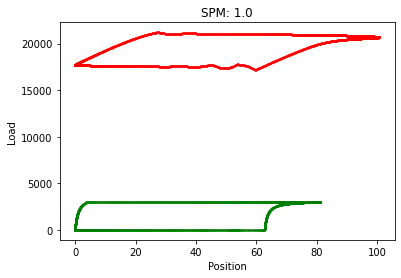

----------------------------------------------
Processing - SPM: 1.2...
Results >>> PPRL: 21326, MPRL: 17065:


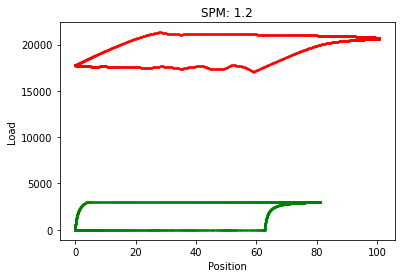

----------------------------------------------
Processing - SPM: 1.4...
Results >>> PPRL: 21437, MPRL: 16960:


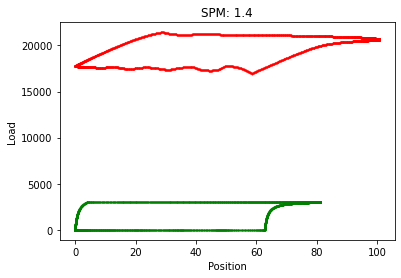

----------------------------------------------
Processing - SPM: 1.6...
Results >>> PPRL: 21550, MPRL: 16855:


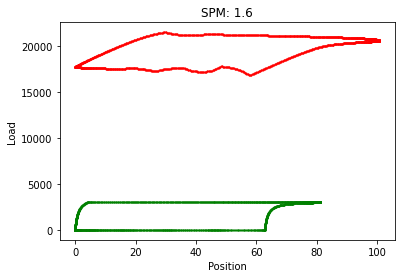

----------------------------------------------
Processing - SPM: 1.8...
Results >>> PPRL: 21664, MPRL: 16756:


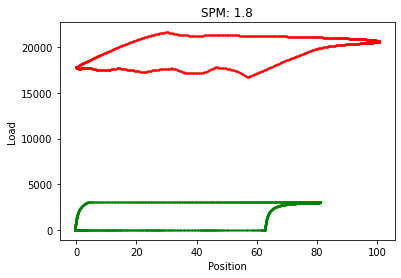

----------------------------------------------
Processing - SPM: 2.0...
Results >>> PPRL: 21778, MPRL: 16634:


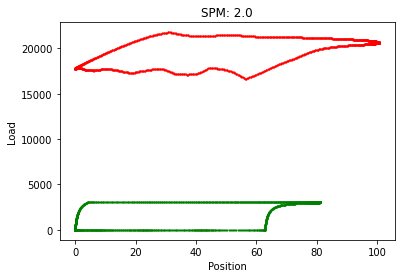

----------------------------------------------
Processing - SPM: 2.2...
Results >>> PPRL: 21889, MPRL: 16526:


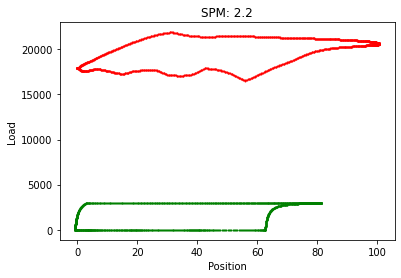

----------------------------------------------
Processing - SPM: 2.4...
Results >>> PPRL: 22013, MPRL: 16411:


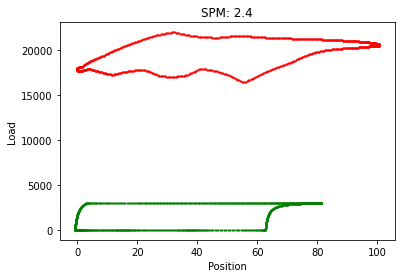

----------------------------------------------
Processing - SPM: 2.6...
Results >>> PPRL: 22123, MPRL: 16310:


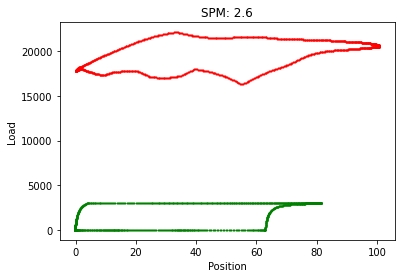

----------------------------------------------
Processing - SPM: 2.8...
Results >>> PPRL: 22247, MPRL: 16171:


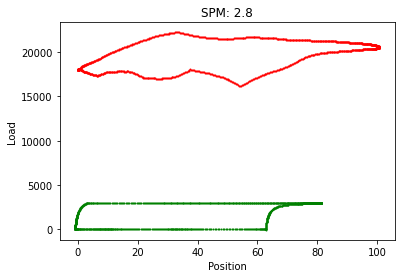

----------------------------------------------
Processing - SPM: 3.0...
Results >>> PPRL: 22356, MPRL: 16085:


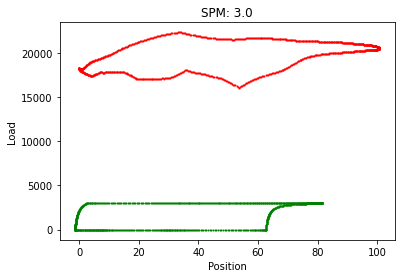

----------------------------------------------
Processing - SPM: 3.2...
Results >>> PPRL: 22475, MPRL: 16005:


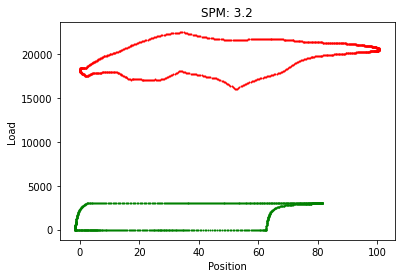

----------------------------------------------
Processing - SPM: 3.4...
Results >>> PPRL: 22617, MPRL: 15943:


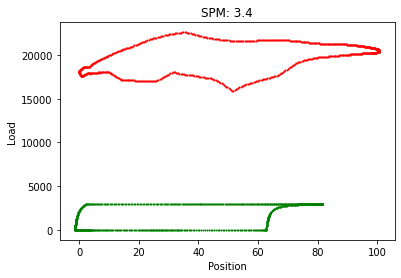

----------------------------------------------
Processing - SPM: 3.6...
Results >>> PPRL: 22728, MPRL: 15853:


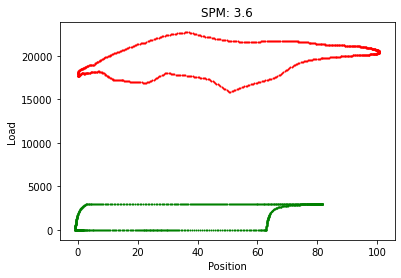

----------------------------------------------
Processing - SPM: 3.8...
Results >>> PPRL: 22831, MPRL: 15748:


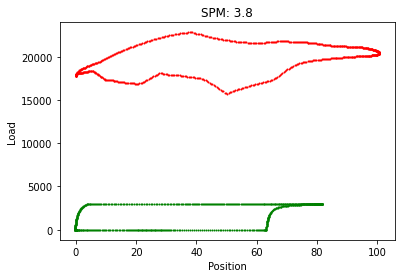

----------------------------------------------
Processing - SPM: 4.0...
Results >>> PPRL: 22926, MPRL: 15619:


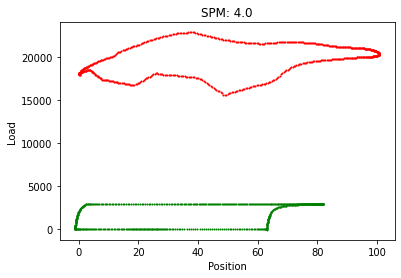

----------------------------------------------
Processing - SPM: 4.2...
Results >>> PPRL: 23091, MPRL: 15540:


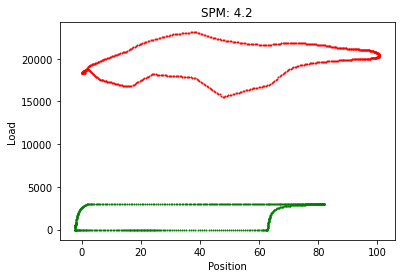

----------------------------------------------
Processing - SPM: 4.4...
Results >>> PPRL: 23241, MPRL: 15429:


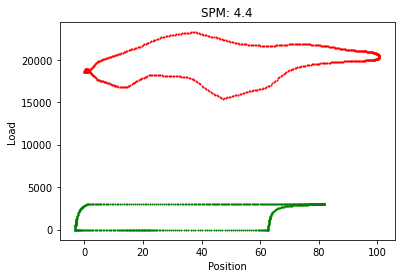

----------------------------------------------
Processing - SPM: 4.6...
Results >>> PPRL: 23341, MPRL: 15329:


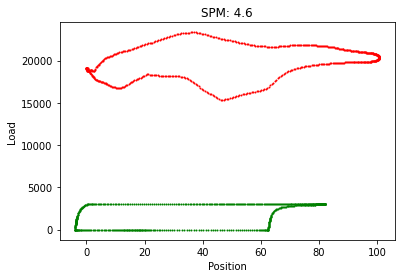

----------------------------------------------
Processing - SPM: 4.8...
Results >>> PPRL: 23420, MPRL: 15211:


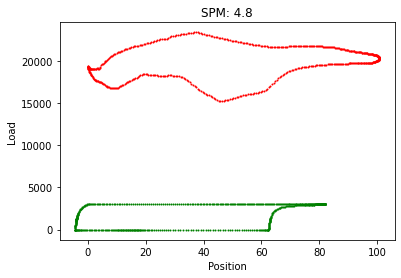

----------------------------------------------
Processing - SPM: 5.0...
Results >>> PPRL: 23450, MPRL: 15106:


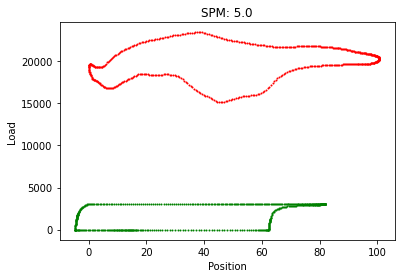

----------------------------------------------
Processing - SPM: 5.2...
Results >>> PPRL: 23550, MPRL: 14983:


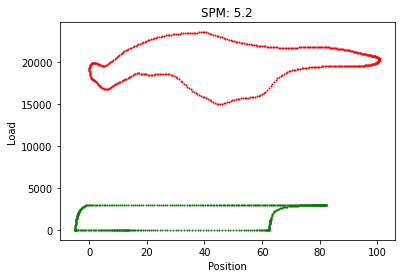

----------------------------------------------
Processing - SPM: 5.4...
Results >>> PPRL: 23872, MPRL: 14830:


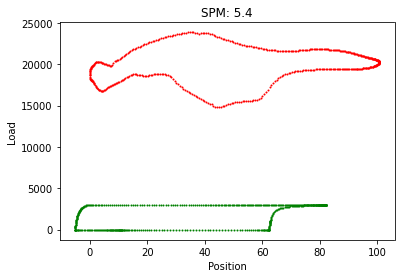

----------------------------------------------
Processing - SPM: 5.6...
Results >>> PPRL: 24194, MPRL: 14700:


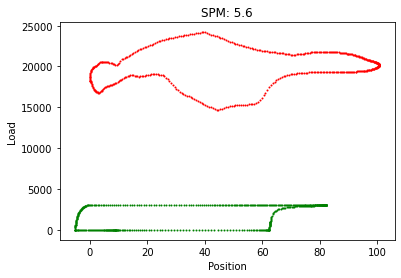

----------------------------------------------
Processing - SPM: 5.8...
Results >>> PPRL: 24175, MPRL: 14609:


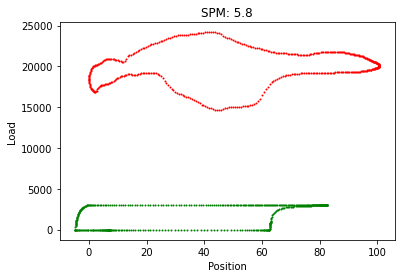

----------------------------------------------
Processing - SPM: 6.0...
Results >>> PPRL: 24166, MPRL: 14486:


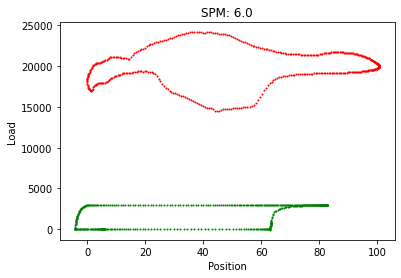

----------------------------------------------
Done processing SPM values.


In [10]:
DoLoop(demo.copy(), "SPM", 1, 6, 0.2)

***